In [1]:
!pip install -q git+https://github.com/huggingface/transformers.git

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done


In [2]:
!pip install datasets

In [3]:
import pandas as pd
import numpy as np
import json

Loading Science QA Dataset using HuggingFace Datasets library

In [4]:
from datasets import load_dataset
dataset = load_dataset("derek-thomas/ScienceQA")

  0%|          | 0/3 [00:00<?, ?it/s]

In [5]:
df_train=pd.DataFrame(dataset['train'])
df_val=pd.DataFrame(dataset['validation'])
df_test=pd.DataFrame(dataset['test'])

In [6]:
df_train['split'] = 'train'
df_val['split'] = 'validation'
df_test['split'] = 'test'

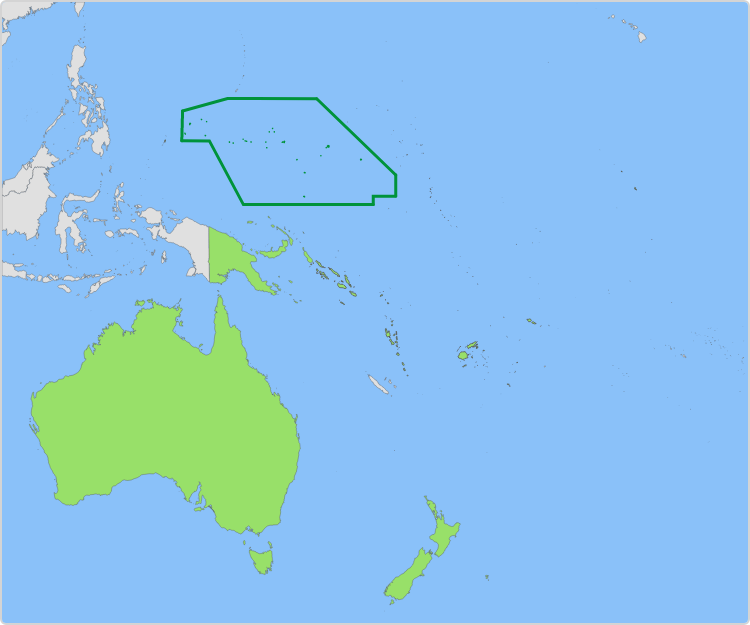

In [15]:
df_train.loc[12714,"image"]

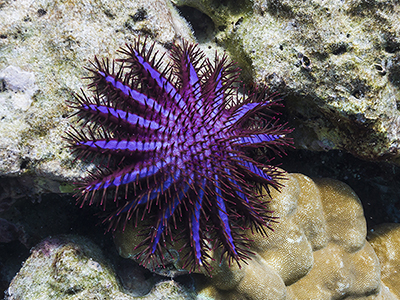

In [11]:
df_train.loc[12646,"image"]

**Loading Pre-Trained ViltProcessor and ViltForQuestionAnswering model**

In [10]:
# Pre-Trained model

from transformers import ViltProcessor, ViltForQuestionAnswering
import requests
from PIL import Image

# prepare image + question
# url = "http://images.cocodataset.org/val2017/000000039769.jpg"
# image = Image.open(requests.get(url, stream=True).raw)
# image = df_train.loc[12714,'image']
# text = "Which country is highlighted?"

# image = df_train.loc[12714,'image']
# text = "Which country is highlighted?"

image = df_train.loc[12646,'image']
text = "Which is this organism's common name?"

processor = ViltProcessor.from_pretrained("dandelin/vilt-b32-finetuned-vqa")
model = ViltForQuestionAnswering.from_pretrained("dandelin/vilt-b32-finetuned-vqa")

# prepare inputs
encoding = processor(image, text, return_tensors="pt")

# forward pass
outputs = model(**encoding)
logits = outputs.logits
idx = logits.argmax(-1).item()
print("Predicted answer:", model.config.id2label[idx])


Predicted answer: fish


In [18]:
df_overall = pd.concat([df_train, df_val,df_test], axis = 0)

**Create Science-QA specific Vocabulary : Corpus**

In [27]:
df_overall['choices'] = df_overall['choices'].apply(lambda x: [i.lower() for i in x])
overall_corpus=df_overall['choices'].apply(lambda x:' '.join(x) + " ").sum()
punc = '''!()-[]{};:'"\,<>./?@#$%^&*_~'''
# Removing punctuations in string
# Using loop + punctuation string
for ele in overall_corpus:
	if ele in punc:
		overall_corpus = overall_corpus.replace(ele, " ")

In [28]:
from nltk.corpus import stopwords
import nltk 
nltk.download('stopwords')
stop_words = set(stopwords.words('english'))
new_corpus=[]
for token in overall_corpus.split(' '):
  if token not in stop_words:
    # if '\n' in token:
    #   print(token),print(token.replace('\n',''))
    #   print('--')
    new_corpus.append(token)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [29]:
overall_corpus=' '.join(new_corpus)
labels_list = set([i for i in overall_corpus.split(' ')])
labels_list=set(([i.replace('\n','') for i in labels_list if '\n' in i])+([i for i in labels_list if '\n' not in i]))
labels_list=([i for i in labels_list if i not in stop_words])
label2id_custom={j:i for i,j in enumerate((labels_list))}
len(label2id_custom.keys())

9093

In [30]:
df_overall = pd.concat([df_train, df_val], axis = 0)
df_overall=df_overall[df_overall['choices'].apply(lambda x:True if len(x)==2 else False)]
df_overall=df_overall[df_overall['image'].notna()].reset_index().rename(columns={'index':'old_index'})
df_overall.loc[:,"row_num"] = df_overall.index

**Appending the model config with new vocab**

In [31]:
from transformers import ViltConfig

config = ViltConfig.from_pretrained("dandelin/vilt-b32-finetuned-vqa")

In [32]:
config.label2id={**label2id_custom,**config.label2id}

In [33]:
c=0
for i in config.label2id.keys():
  config.label2id[i]=c
  c+=1
config.id2label={j:i for i,j in config.label2id.items()}
len(config.label2id)==len(config.id2label)

True

**Creating Annotations**

In [34]:
from collections import Counter
def row_annotation(row):
  annotation_dict={}
  annotation_dict['question_type']=row.question
  annotation_dict['multiple_choice_answer']=row.answer

  correct_occurence=Counter(row.choices[row.answer].split(' '))
  overall_occurence=Counter(' '.join(row.choices).split(' '))
  scores_dict={i:(correct_occurence.get(i,0)/j) for i,j in overall_occurence.items()}
  
  annotation_dict['answers']=[i for i,j in scores_dict.items() if i in config.label2id.keys()]
  # annotation_dict['answers']=[]
  annotation_dict['image_id']=row.row_num
  annotation_dict['answer_type']='binary mcq'
  annotation_dict['question_id']=row.row_num
  

  
  annotation_dict['labels']=[config.label2id[i] for i,j in scores_dict.items() if i in config.label2id.keys()]
  annotation_dict['scores']=[scores_dict[i] for i,j in scores_dict.items() if i in config.label2id.keys()]
  
  return annotation_dict
  # return row

In [35]:
annotations = [i for i in df_overall.apply(lambda x:row_annotation(x),axis=1)]
questions = [{'question': i['question_type'], 'question_id':i['question_id'] , 'image_id': i['image_id']} for i in annotations]

**Creating Train and Test DataLoader using Pytorch**

In [36]:
import torch
from PIL import Image

class ScienceQADataset(torch.utils.data.Dataset):
    """Science QA (2 choice questions) dataset."""

    def __init__(self, questions, annotations, processor):
        self.questions = questions
        self.annotations = annotations
        self.processor = processor

    def __len__(self):
        return len(self.annotations)

    def __getitem__(self, idx):
        # get image + text
        annotation = self.annotations[idx]
        questions = self.questions[idx]
        image = df_overall.loc[annotation['image_id'],'image']
        image = image.convert('RGB')
        text = questions['question']
        
        encoding = self.processor(image, text, padding="max_length", truncation=True, return_tensors="pt")
        # print(encoding.shape)
        # print("done")
        # remove batch dimension
        for k,v in encoding.items():
          encoding[k] = v.squeeze()
        # add labels
        labels = annotation['labels']
        scores = annotation['scores']
        # based on: https://github.com/dandelin/ViLT/blob/762fd3975c180db6fc88f577cf39549983fa373a/vilt/modules/objectives.py#L301
        targets = torch.zeros(len(config.id2label))
        
        for label, score in zip(labels, scores):
              targets[label] = score
        encoding["labels"] = targets

        return encoding

In [37]:
from transformers import ViltProcessor

processor = ViltProcessor.from_pretrained("dandelin/vilt-b32-mlm")

In [38]:
train_indices = list(df_overall[df_overall["split"] == "train"].index)
train_questions = [questions[i] for i in train_indices]
train_annotations = [annotations[i] for i in train_indices]
train_dataset = ScienceQADataset(questions=train_questions,
                     annotations=train_annotations,
                     processor=processor)

In [39]:
processor.decode(train_dataset[0]['input_ids'])

"[CLS] identify the question that tom and justin's experiment can best answer. [SEP] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD]"

**Model Training**

In [40]:
from transformers import ViltForQuestionAnswering

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [41]:
device

device(type='cuda')

In [42]:
model = ViltForQuestionAnswering.from_pretrained("dandelin/vilt-b32-mlm",
                                                 num_labels=len(config.id2label),
                                                 id2label=config.id2label,
                                                 label2id=config.label2id)
model.to(device)

Some weights of the model checkpoint at dandelin/vilt-b32-mlm were not used when initializing ViltForQuestionAnswering: ['mlm_score.transform.dense.bias', 'mlm_score.transform.LayerNorm.weight', 'mlm_score.transform.dense.weight', 'mlm_score.transform.LayerNorm.bias', 'mlm_score.bias', 'mlm_score.decoder.weight']
- This IS expected if you are initializing ViltForQuestionAnswering from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing ViltForQuestionAnswering from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of ViltForQuestionAnswering were not initialized from the model checkpoint at dandelin/vilt-b32-mlm and are newly initialized: ['classifier.1.bias', 'classifier.1.weight', 'classifier.3.bia

ViltForQuestionAnswering(
  (vilt): ViltModel(
    (embeddings): ViltEmbeddings(
      (text_embeddings): TextEmbeddings(
        (word_embeddings): Embedding(30522, 768)
        (position_embeddings): Embedding(40, 768)
        (token_type_embeddings): Embedding(2, 768)
        (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
        (dropout): Dropout(p=0.0, inplace=False)
      )
      (patch_embeddings): ViltPatchEmbeddings(
        (projection): Conv2d(3, 768, kernel_size=(32, 32), stride=(32, 32))
      )
      (token_type_embeddings): Embedding(2, 768)
      (dropout): Dropout(p=0.0, inplace=False)
    )
    (encoder): ViltEncoder(
      (layer): ModuleList(
        (0-11): 12 x ViltLayer(
          (attention): ViltAttention(
            (attention): ViltSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=76

In [ ]:
from torch.utils.data import DataLoader

def collate_fn(batch):
  input_ids = [item['input_ids'] for item in batch]
  pixel_values = [item['pixel_values'] for item in batch]
  attention_mask = [item['attention_mask'] for item in batch]
  token_type_ids = [item['token_type_ids'] for item in batch]
  labels = [item['labels'] for item in batch]
  
  # create padded pixel values and corresponding pixel mask
  encoding = processor.feature_extractor.pad_and_create_pixel_mask(pixel_values, return_tensors="pt")
  
  # create new batch
  batch = {}
  batch['input_ids'] = torch.stack(input_ids)
  batch['attention_mask'] = torch.stack(attention_mask)
  batch['token_type_ids'] = torch.stack(token_type_ids)
  batch['pixel_values'] = encoding['pixel_values']
  batch['pixel_mask'] = encoding['pixel_mask']
  batch['labels'] = torch.stack(labels)
  
  return batch

train_dataloader = DataLoader(train_dataset, collate_fn=collate_fn, batch_size=16, shuffle=True)

In [ ]:
batch = next(iter(train_dataloader))

/usr/local/lib/python3.9/dist-packages/transformers/models/vilt/processing_vilt.py:142: FutureWarning: `feature_extractor` is deprecated and will be removed in v5. Use `image_processor` instead.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/transformers/models/vilt/image_processing_vilt.py:357: FutureWarning: This method is deprecated and will be removed in v4.26.0. Please use pad instead.
  warnings.warn(


In [ ]:
for k,v in batch.items():
  print(k, v.shape)

input_ids torch.Size([16, 40])
attention_mask torch.Size([16, 40])
token_type_ids torch.Size([16, 40])
pixel_values torch.Size([16, 3, 608, 608])
pixel_mask torch.Size([16, 608, 608])
labels torch.Size([16, 10777])


In [ ]:
from tqdm.notebook import tqdm
optimizer = torch.optim.AdamW(model.parameters(), lr=5e-5)

model.train(True)
loss_dict_new={}
for epoch in range(10):  # loop over the dataset multiple times
   print(f"Epoch: {epoch}")
   for batch in tqdm(train_dataloader):
        # get the inputs; 
        batch = {k:v.to(device) for k,v in batch.items()}

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = model(**batch)
        loss = outputs.loss
        print("Loss:", loss.item())
        loss.backward()
        optimizer.step()
   loss_dict_new[epoch]=loss

**Inference**

In [ ]:
val_indices = list(df_overall[df_overall["split"] == "validation"].index)
val_questions = [questions[i] for i in val_indices]
val_annotations = [annotations[i] for i in val_indices]
val_dataset = ScienceQADataset(questions=val_questions,
                     annotations=val_annotations,
                     processor=processor)

In [ ]:
# add batch dimension + move to GPU
example = {k: v.unsqueeze(0).to(device) for k,v in example.items()}

In [ ]:
outputs = model(**example)

In [ ]:
logits = outputs.logits
predicted_class = logits.argmax(-1).item()
print("Predicted answer:", model.config.id2label[predicted_class])

In [ ]:
[model.config.id2label[i.item()] for i in torch.topk(logits.flatten(), 5).indices]

*Caption Generation through ViT*

In [ ]:

from transformers import VisionEncoderDecoderModel, ViTImageProcessor, AutoTokenizer
import torch
from PIL import Image

model = VisionEncoderDecoderModel.from_pretrained("nlpconnect/vit-gpt2-image-captioning")
feature_extractor = ViTImageProcessor.from_pretrained("nlpconnect/vit-gpt2-image-captioning")
tokenizer = AutoTokenizer.from_pretrained("nlpconnect/vit-gpt2-image-captioning")

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)



max_length = 64
num_beams = 4
gen_kwargs = {"max_length": max_length, "num_beams": num_beams}
def predict_step(image):
  images = []
  # for image_path in image_paths:
  #   i_image = Image.open(image_path)
  #   if i_image.mode != "RGB":
  #     i_image = i_image.convert(mode="RGB")

  images.append(image)

  pixel_values = feature_extractor(images=images, return_tensors="pt").pixel_values
  pixel_values = pixel_values.to(device)

  output_ids = model.generate(pixel_values, **gen_kwargs)

  preds = tokenizer.batch_decode(output_ids, skip_special_tokens=True)
  preds = [pred.strip() for pred in preds]
  return preds


# predict_step([]) # ['a woman in a hospital bed with a woman in a hospital bed']


In [ ]:
df_train.loc[23,'image']

In [ ]:
predict_step(df_train.loc[23,"image"])